Code for testing and the development of the simple bump modes scenario

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.latent_regression.scenarios import BumpInputWithRecursiveDynamicsScenario
from janelia_core.ml.latent_regression.scenarios import plot_2d_conditional_prior
from janelia_core.ml.latent_regression.scenarios import plot_2d_modes

from janelia_core.ml.latent_regression.vi import MultiSubjectVIFitter
from janelia_core.ml.utils import list_torch_devices

### Parameters go here

In [3]:
n_subjects = 17
n_modes = 2
n_neuron_range = [1000, 1000]
n_dims = 2
n_smps_range = [1000, 1100]
prior_std = .01
noise_range = [1, 2]
bump_std_range = [.2, .2]

#### See what devices are available for computation

In [4]:
devices, cuda_is_available = list_torch_devices()

Found 2 GPUs


### Generate priors and subject models

In [5]:
true_mdls = BumpInputWithRecursiveDynamicsScenario(n_subjects=n_subjects, 
                                                   n_modes=n_modes, 
                                                   n_neuron_range=n_neuron_range, 
                                                   n_dims=n_dims,
                                                   prior_std=prior_std, 
                                                   noise_range=noise_range, 
                                                   bump_std_range=bump_std_range)

### View prior modes

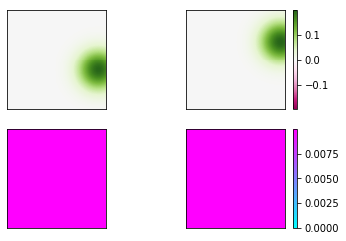

In [6]:
plot_2d_conditional_prior(true_mdls.input_u_prior)

### View modes for a given model

In [7]:
plot_s = 0

In [8]:
u = true_mdls.subject_mdls[plot_s].u[0].detach().numpy()
internal_p = true_mdls.subject_mdls[plot_s].p[1].detach().numpy()
neuron_p = true_mdls.subject_mdls[plot_s].neuron_pos.numpy()

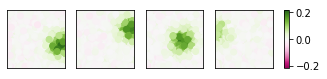

In [9]:
plot_2d_modes(modes=u, neuron_p=neuron_p)

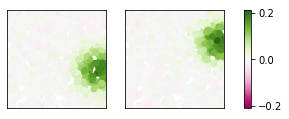

In [10]:
plot_2d_modes(modes=internal_p, neuron_p=neuron_p)

### Generate data from the models

In [11]:
n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+ 1, n_subjects)
subject_data = true_mdls.generate_random_input_data(n_smps, input_std=100)

### Fit one model use maximum likelihood

In [12]:
fit_s = 0

In [13]:
fit_data = subject_data[fit_s][0:-1]
fit_x = [t[fit_data.i_x,:] for t in fit_data.data]
fit_y = [fit_data.data[1][fit_data.i_y,:]]

In [14]:
fit_mdl = true_mdls.generate_training_subject_mdl(fit_s)

In [15]:
log = fit_mdl.fit(x=fit_x, y=fit_y, update_int=100, max_its=3000, 
                          learning_rates=.001, batch_size=100, send_size=100)

0: Elapsed fitting time 5.030632019042969e-05, vl: 816858.06, lr: 0.001
100: Elapsed fitting time 6.715154409408569, vl: 59494.848, lr: 0.001
200: Elapsed fitting time 10.28255558013916, vl: 34326.246, lr: 0.001
300: Elapsed fitting time 17.06821846961975, vl: 21370.615, lr: 0.001
400: Elapsed fitting time 19.777758598327637, vl: 15500.029, lr: 0.001
500: Elapsed fitting time 24.936095237731934, vl: 10259.054, lr: 0.001
600: Elapsed fitting time 27.04038095474243, vl: 5547.304, lr: 0.001
700: Elapsed fitting time 30.45430898666382, vl: 3883.3296, lr: 0.001
800: Elapsed fitting time 35.02174663543701, vl: 3458.7415, lr: 0.001
900: Elapsed fitting time 38.488675117492676, vl: 3268.9697, lr: 0.001
1000: Elapsed fitting time 39.54537105560303, vl: 3182.515, lr: 0.001
1100: Elapsed fitting time 40.836888551712036, vl: 3109.6238, lr: 0.001
1200: Elapsed fitting time 41.872978925704956, vl: 3061.942, lr: 0.001
1300: Elapsed fitting time 45.99534583091736, vl: 2998.7905, lr: 0.001
1400: Elapse

#### Look at fit u modes

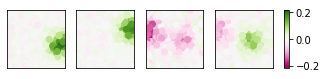

In [16]:
u_fit = fit_mdl.u[0].detach().numpy()
internal_p_fit = fit_mdl.p[1].detach().numpy()
neuron_p_fit = true_mdls.subject_mdls[fit_s].neuron_pos.detach()

plot_2d_modes(modes=u_fit, neuron_p=neuron_p_fit)

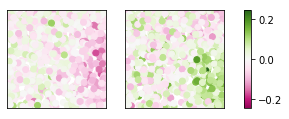

In [17]:
plot_2d_modes(modes=internal_p_fit, neuron_p=neuron_p_fit)

## Explore fitting with a shared posterior

In [18]:
shared_posteriors = true_mdls.generate_shared_posteriors()

In [19]:
sp_subject_collections = [true_mdls.generate_training_collection(s_i=s_i, data=data[:], 
                                                              post_dists=shared_posteriors)
                       for s_i, data in enumerate(subject_data)]

In [20]:
sp_vi_fitter = MultiSubjectVIFitter(p_priors=None, u_priors=None, 
                                 s_collections=sp_subject_collections)

In [21]:
sp_vi_fitter.distribute(devices=devices, distribute_data=True)
logs=sp_vi_fitter.fit(n_epochs=200, n_batches=2, update_int=50, 
                   learning_rates=.01, enforce_priors=False, sample_posteriors=True)

*****************************************************
Epoch 0 complete.  Obj: 7.50e+11, LR: 0.01
Model NLLs:  s_0: 3.15e+10, s_1: 7.32e+10, s_2: 3.55e+10, s_3: 5.41e+10, s_4: 6.52e+10, s_5: 3.45e+10, s_6: 3.75e+10, s_7: 6.57e+10, s_8: 2.49e+10, s_9: 9.26e+10, s_10: 2.63e+10, s_11: 2.76e+10, s_12: 3.99e+10, s_13: 2.71e+10, s_14: 2.49e+10, s_15: 4.21e+10, s_16: 4.72e+10
Subj P KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00, s_3: 0.00e+00, s_4: 0.00e+00, s_5: 0.00e+00, s_6: 0.00e+00, s_7: 0.00e+00, s_8: 0.00e+00, s_9: 0.00e+00, s_10: 0.00e+00, s_11: 0.00e+00, s_12: 0.00e+00, s_13: 0.00e+00, s_14: 0.00e+00, s_15: 0.00e+00, s_16: 0.00e+00
Subj U KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00, s_3: 0.00e+00, s_4: 0.00e+00, s_5: 0.00e+00, s_6: 0.00e+00, s_7: 0.00e+00, s_8: 0.00e+00, s_9: 0.00e+00, s_10: 0.00e+00, s_11: 0.00e+00, s_12: 0.00e+00, s_13: 0.00e+00, s_14: 0.00e+00, s_15: 0.00e+00, s_16: 0.00e+00
Subj l2 W Penalties:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00, s_3: 0.00e+00,

### Look at fit posteriors for u modes

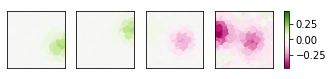

In [22]:
neuron_pos = sp_subject_collections[0].props[0]
u_mn = sp_subject_collections[0].u_dists[0](neuron_pos).cpu().detach().numpy()
plot_2d_modes(modes=u_mn, neuron_p=neuron_pos.cpu().detach().numpy())


### Look at fit posteriors for internal p modes

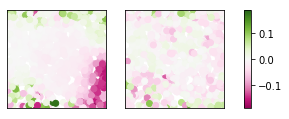

In [23]:
p_mn = sp_subject_collections[0].p_dists[1](neuron_pos).cpu().detach().numpy()
plot_2d_modes(modes=p_mn, neuron_p=neuron_pos.cpu().detach().numpy())

### Fit everything with variational inference

In [24]:
prior_dists = true_mdls.generate_fitting_priors(n_divisions_per_dim=50, n_div_per_hc_side_per_dim=1)

In [25]:
subject_collections = [true_mdls.generate_training_collection(s_i=s_i, data=data[:])
                      for s_i, data in enumerate(subject_data)]

In [26]:
vi_fitter = MultiSubjectVIFitter(p_priors=prior_dists[0], u_priors=prior_dists[1], 
                                 s_collections=subject_collections)

In [27]:
vi_fitter.distribute(devices=devices, distribute_data=True)
logs=vi_fitter.fit(n_epochs=1000, n_batches=2, update_int=100, 
                   learning_rates=.001)

*****************************************************
Epoch 0 complete.  Obj: 1.69e+10, LR: 0.001
Model NLLs:  s_0: 8.33e+08, s_1: 1.46e+09, s_2: 8.33e+08, s_3: 1.09e+09, s_4: 1.43e+09, s_5: 7.96e+08, s_6: 1.10e+09, s_7: 1.41e+09, s_8: 6.83e+08, s_9: 1.68e+09, s_10: 6.66e+08, s_11: 6.24e+08, s_12: 9.42e+08, s_13: 7.15e+08, s_14: 6.41e+08, s_15: 9.24e+08, s_16: 1.02e+09
Subj P KLs:  s_0: 1.84e+05, s_1: 1.86e+05, s_2: 1.86e+05, s_3: 1.91e+05, s_4: 1.90e+05, s_5: 1.93e+05, s_6: 1.89e+05, s_7: 1.87e+05, s_8: 1.87e+05, s_9: 1.95e+05, s_10: 1.91e+05, s_11: 1.82e+05, s_12: 1.87e+05, s_13: 1.89e+05, s_14: 1.87e+05, s_15: 1.88e+05, s_16: 1.93e+05
Subj U KLs:  s_0: 3.66e+05, s_1: 3.68e+05, s_2: 3.67e+05, s_3: 3.80e+05, s_4: 3.69e+05, s_5: 3.69e+05, s_6: 3.68e+05, s_7: 3.66e+05, s_8: 3.72e+05, s_9: 3.75e+05, s_10: 3.66e+05, s_11: 3.72e+05, s_12: 3.72e+05, s_13: 3.77e+05, s_14: 3.74e+05, s_15: 3.69e+05, s_16: 3.76e+05
Subj l2 W Penalties:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00, s_3: 0.00e+00

*****************************************************
Epoch 700 complete.  Obj: 1.21e+08, LR: 0.001
Model NLLs:  s_0: 5.59e+06, s_1: 8.38e+06, s_2: 6.47e+06, s_3: 7.66e+06, s_4: 1.09e+07, s_5: 5.79e+06, s_6: 6.93e+06, s_7: 9.01e+06, s_8: 5.22e+06, s_9: 8.48e+06, s_10: 5.34e+06, s_11: 4.84e+06, s_12: 5.85e+06, s_13: 5.46e+06, s_14: 5.03e+06, s_15: 5.69e+06, s_16: 7.74e+06
Subj P KLs:  s_0: 9.52e+04, s_1: 1.20e+05, s_2: 9.06e+04, s_3: 1.07e+05, s_4: 1.33e+05, s_5: 1.09e+05, s_6: 1.16e+05, s_7: 1.41e+05, s_8: 9.89e+04, s_9: 1.31e+05, s_10: 9.46e+04, s_11: 9.90e+04, s_12: 1.01e+05, s_13: 1.09e+05, s_14: 8.50e+04, s_15: 1.20e+05, s_16: 1.14e+05
Subj U KLs:  s_0: 2.30e+05, s_1: 2.25e+05, s_2: 2.43e+05, s_3: 2.27e+05, s_4: 2.88e+05, s_5: 2.74e+05, s_6: 2.54e+05, s_7: 3.07e+05, s_8: 2.40e+05, s_9: 2.47e+05, s_10: 2.99e+05, s_11: 2.40e+05, s_12: 2.35e+05, s_13: 2.88e+05, s_14: 2.50e+05, s_15: 2.98e+05, s_16: 2.46e+05
Subj l2 W Penalties:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00, s_3: 0.00e+

#### Look at log values

Text(0.5, 0, 'Elapsed Time')

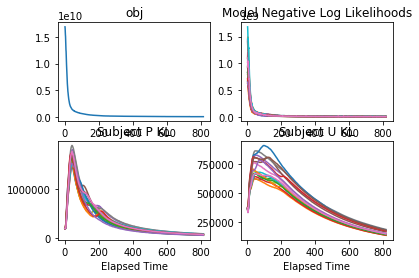

In [28]:
plt.subplot(2,2,1)
plt.plot(logs['elapsed_time'], logs['obj'])
plt.title('obj')
plt.xlabel('Elapsed Time')

plt.subplot(2,2,2)
plt.plot(logs['elapsed_time'], logs['mdl_nll'])
plt.title('Model Negative Log Likelihoods')
plt.xlabel('Elapsed Time')

plt.subplot(2,2,3)
plt.plot(logs['elapsed_time'], logs['sub_p_kl'])
plt.title('Subject P KL')
plt.xlabel('Elapsed Time')

plt.subplot(2,2,4)
plt.plot(logs['elapsed_time'], logs['sub_u_kl'])
plt.title('Subject U KL')
plt.xlabel('Elapsed Time')

#### Look at fit modes for one subject

In [38]:
fit_s = 4
neuron_u_pos = true_mdls.subject_mdls[fit_s].neuron_pos

u_mn = subject_collections[fit_s].u_dists[0].form_standard_sample(
    subject_collections[fit_s].u_dists[0].sample(neuron_u_pos)).cpu().detach().numpy()

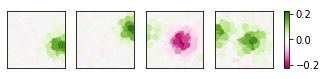

In [39]:
plot_2d_modes(modes=u_mn, neuron_p=neuron_u_pos)

#### Look at prior modes

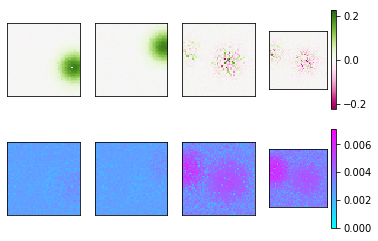

In [31]:
plot_2d_conditional_prior(prior_dists[1][0].to('cpu'))

### Compare prior to posterior modes for one subject

In [ ]:
fit_s = 1

In [ ]:
neuron_u_pos = true_mdls.subject_mdls[fit_s].neuron_pos
u_prior = prior_dists[1][0]

with torch.no_grad():
    u_post_mn = subject_collections[fit_s].u_dists[0](neuron_u_pos).cpu().numpy()
    u_prior_mn = u_prior(neuron_u_pos).cpu().numpy()

In [ ]:
plot_2d_modes(modes=u_post_mn, neuron_p=neuron_u_pos)

In [ ]:
plot_2d_modes(modes=u_prior_mn, neuron_p=neuron_u_pos)

In [ ]:
plot_2d_modes(modes=u_post_mn-u_prior_mn, neuron_p=neuron_u_pos)

In [ ]:
neuron_u_pos = true_mdls.subject_mdls[fit_s].neuron_pos

u_prior = prior_dists[1][0]
u_post = subject_collections[0].u_dists[0]

smp = u_post.sample(neuron_u_pos)

In [ ]:
d0 = u_post.dists[0]
d1 = u_prior.dists[0]

In [ ]:
torch.mean(d0.kl(d1,x=neuron_u_pos,smp=smp[0]))

In [ ]:
torch.mean(d0.kl(d1,x=neuron_u_pos,smp=None))